2025-03-25 14:03:05.153986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 14:03:05.167881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742907785.185438 2074160 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742907785.191522 2074160 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742907785.207973 2074160 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

No GPU available. Running on CPU.
Reynolds number: 10000.0
No saved model found. Starting training from scratch.


2025-03-25 14:03:08.216941: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-25 14:03:08.216960: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-03-25 14:03:08.216963: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: arubuntu
2025-03-25 14:03:08.216966: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: arubuntu
2025-03-25 14:03:08.217028: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.183.1
2025-03-25 14:03:08.217037: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 535.183.1
202

Epoch 0, Loss: 0.37104, Grad Norm: 0.60218
Epoch 100, Loss: 0.08423, Grad Norm: 0.14734
Epoch 200, Loss: 0.03284, Grad Norm: 0.07854
Epoch 300, Loss: 0.04447, Grad Norm: 0.36883
Epoch 400, Loss: 0.02511, Grad Norm: 0.08001
Epoch 500, Loss: 0.02882, Grad Norm: 0.14986
Epoch 600, Loss: 0.02439, Grad Norm: 0.13941
Epoch 700, Loss: 0.02189, Grad Norm: 0.06277
Epoch 800, Loss: 0.02302, Grad Norm: 0.13067
Epoch 900, Loss: 0.02068, Grad Norm: 0.04196
Epoch 1000, Loss: 0.02325, Grad Norm: 0.17150
Epoch 1100, Loss: 0.01956, Grad Norm: 0.00108
Epoch 1200, Loss: 0.01931, Grad Norm: 0.00065
Epoch 1300, Loss: 0.01903, Grad Norm: 0.00066
Epoch 1400, Loss: 0.01870, Grad Norm: 0.00070
Epoch 1500, Loss: 0.01829, Grad Norm: 0.00073
Epoch 1600, Loss: 0.01780, Grad Norm: 0.00076
Epoch 1700, Loss: 0.01722, Grad Norm: 0.00077
Epoch 1800, Loss: 0.01660, Grad Norm: 0.00077
Epoch 1900, Loss: 0.01598, Grad Norm: 0.00076
Epoch 2000, Loss: 0.01559, Grad Norm: 0.04522
Epoch 2100, Loss: 0.01489, Grad Norm: 0.00075


/home/adil/.anaconda3/envs/ham/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


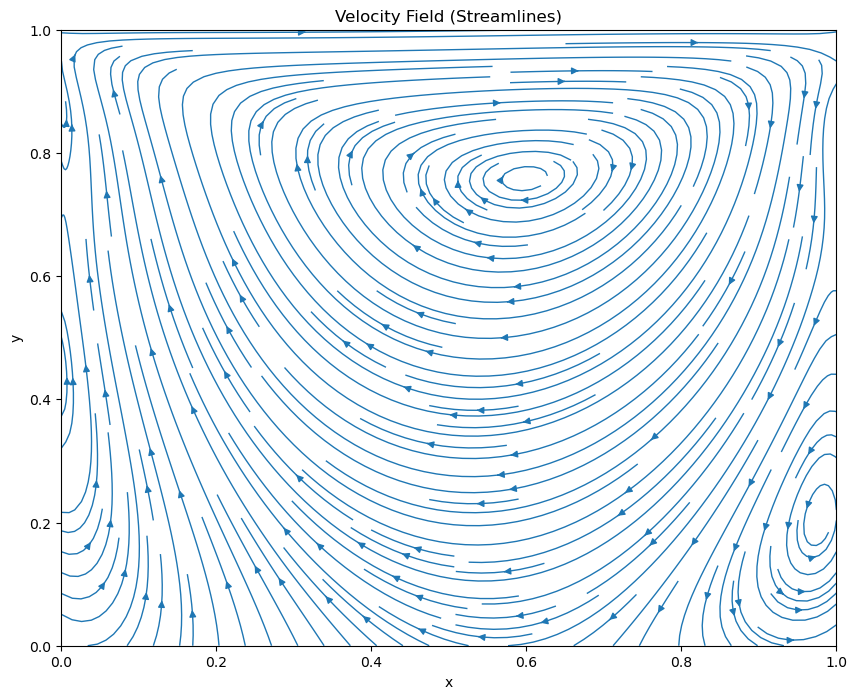

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Problem parameters
nu = 0.01  # Molecular kinematic viscosity
U_lid = 1.0  # Lid velocity
L = 100.0    # Characteristics length
Re_t = U_lid * L/ nu # Reynolds number for turbulence
print(f"Reynolds number: {Re_t}")


# Domain boundaries
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0


# Neural network definition
class TurbulentPINN(tf.keras.Model):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=40, **kwargs):
        super(TurbulentPINN, self).__init__(**kwargs)
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer

        # Define hidden layers as a Sequential model
        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(
                num_neurons_per_layer,
                activation='tanh',
                kernel_initializer='glorot_normal',
                kernel_regularizer=tf.keras.regularizers.L2(1e-4)
            )
            for _ in range(num_hidden_layers)
        ])

        self.u_output = tf.keras.layers.Dense(1, activation=None)
        self.v_output = tf.keras.layers.Dense(1, activation=None)
        self.p_output = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        X = self.hidden_layers(inputs)
        u = self.u_output(X)
        v = self.v_output(X)
        p = self.p_output(X)
        return u, v, p

    def get_config(self):
        # Serialize the model's configuration
        config = super(TurbulentPINN, self).get_config()
        config.update({
            "num_hidden_layers": self.num_hidden_layers,
            "num_neurons_per_layer": self.num_neurons_per_layer
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Deserialize the model's configuration
        return cls(**config)

# Collocation and boundary points
N_f = 10000  # Collocation points
N_b = 2000   # Boundary points

x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=tf.float32)
y_f = tf.random.uniform((N_f, 1), y_min, y_max, dtype=tf.float32)
X_f_tensor = tf.concat([x_f, y_f], axis=1)

x_left = x_min * tf.ones((N_b // 4, 1), dtype=tf.float32)
y_left = tf.random.uniform((N_b // 4, 1), y_min, y_max, dtype=tf.float32)

x_right = x_max * tf.ones((N_b // 4, 1), dtype=tf.float32)
y_right = tf.random.uniform((N_b // 4, 1), y_min, y_max, dtype=tf.float32)

x_bottom = tf.random.uniform((N_b // 4, 1), x_min, x_max, dtype=tf.float32)
y_bottom = y_min * tf.ones((N_b // 4, 1), dtype=tf.float32)

x_top = tf.random.uniform((N_b // 4, 1), x_min, x_max, dtype=tf.float32)
y_top = y_max * tf.ones((N_b // 4, 1), dtype=tf.float32)

X_b_tensor = tf.concat([
    tf.concat([x_left, y_left], axis=1),
    tf.concat([x_right, y_right], axis=1),
    tf.concat([x_bottom, y_bottom], axis=1),
    tf.concat([x_top, y_top], axis=1)
], axis=0)

u_top = U_lid * tf.ones((N_b // 4, 1), dtype=tf.float32)
v_top = tf.zeros((N_b // 4, 1), dtype=tf.float32)

u_side = tf.zeros((3 * N_b // 4, 1), dtype=tf.float32)
v_side = tf.zeros((3 * N_b // 4, 1), dtype=tf.float32)

u_b_tensor = tf.concat([u_side, u_top], axis=0)
v_b_tensor = tf.concat([v_side, v_top], axis=0)

# Define the loss function
@tf.function
def loss_fn(model, X_f, X_b, u_b, v_b):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X_f)
        u, v, p = model(X_f)
        u = tf.squeeze(u)
        v = tf.squeeze(v)
        p = tf.squeeze(p)

        u_x = tape.gradient(u, X_f)[:, 0]
        u_y = tape.gradient(u, X_f)[:, 1]
        v_x = tape.gradient(v, X_f)[:, 0]
        v_y = tape.gradient(v, X_f)[:, 1]


        u_xx = tape.gradient(u_x, X_f)[:, 0]
        u_yy = tape.gradient(u_y, X_f)[:, 1]
        v_xx = tape.gradient(v_x, X_f)[:, 0]
        v_yy = tape.gradient(v_y, X_f)[:, 1]

    p_x = tape.gradient(p, X_f)[:, 0]
    p_y = tape.gradient(p, X_f)[:, 1]

    del tape

    nu_eff = nu + 0.01  # Effective viscosity (with eddy viscosity)
    continuity = u_x + v_y
    momentum_u = u * u_x + v * u_y + p_x - nu_eff * (u_xx + u_yy)
    momentum_v = u * v_x + v * v_y + p_y - nu_eff * (v_xx + v_yy)

    u_pred_b, v_pred_b, _ = model(X_b)
    bc_loss = tf.reduce_mean(tf.square(u_pred_b - u_b)) + tf.reduce_mean(tf.square(v_pred_b - v_b))

    pde_loss = tf.reduce_mean(tf.square(continuity)) + \
               tf.reduce_mean(tf.square(momentum_u)) + \
               tf.reduce_mean(tf.square(momentum_v))

    return pde_loss + bc_loss

# Initialize the model
model = TurbulentPINN()

# Define the optimizer for the Adam phase
initial_learning_rate = 5e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[1000, 5000, 20000],
    values=[initial_learning_rate, 1e-3, 5e-4, 1e-4]
)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def adam_train_step():
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model, X_f_tensor, X_b_tensor, u_b_tensor, v_b_tensor)
    grads = tape.gradient(loss_value, model.trainable_variables)

    # Clip gradients to improve training stability
    clipped_grads = [tf.clip_by_norm(g, 1.0) if g is not None else None for g in grads]
    adam_optimizer.apply_gradients([(g, v) for g, v in zip(clipped_grads, model.trainable_variables) if g is not None])

    # Compute gradient norm as a metric for monitoring
    grad_norm = tf.reduce_mean([tf.norm(g) for g in grads if g is not None])
    return loss_value, grad_norm

# Helper function to flatten and set model weights for L-BFGS
def flatten_weights(model):
    return tf.concat([tf.reshape(var, [-1]) for var in model.trainable_variables], axis=0)

def set_weights_from_flat(model, flat_params):
    idx = 0
    new_weights = []
    for var in model.trainable_variables:
        var_shape = tf.shape(var).numpy()
        var_size = tf.reduce_prod(var_shape).numpy()
        new_weight = tf.reshape(flat_params[idx:idx + var_size], var_shape)
        new_weights.append(new_weight)
        idx += var_size
    model.set_weights(new_weights)

# L-BFGS optimizer function
def lbfgs_train_step():
    def loss_and_grads(flat_params):
        set_weights_from_flat(model, flat_params)
        with tf.GradientTape() as tape:
            loss_value = loss_fn(model, X_f_tensor, X_b_tensor, u_b_tensor, v_b_tensor)
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = [tf.zeros_like(var) if g is None else g for g, var in zip(grads, model.trainable_variables)]
        grads_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
        return loss_value, grads_flat

    initial_params = flatten_weights(model)
    result = tfp.optimizer.lbfgs_minimize(
        loss_and_grads,
        initial_position=initial_params,
        tolerance=1e-8,
        max_iterations=500
    )
    set_weights_from_flat(model, result.position)
    return result

# Visualization component
def visualize_results(model):
    nx, ny = 50, 50
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)

    XY = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    u_pred, v_pred, _ = model(tf.convert_to_tensor(XY, dtype=tf.float32))

    u_pred = u_pred.numpy().reshape((ny, nx))
    v_pred = v_pred.numpy().reshape((ny, nx))

    plt.figure(figsize=(10, 8))
    plt.streamplot(X, Y, u_pred, v_pred, density=2, linewidth=1, arrowsize=1)
    plt.title('Velocity Field (Streamlines)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


# Train the model with both Adam and L-BFGS optimizers
def train_model():
    model = TurbulentPINN()

    model_dir = "model_directory"
    model_name = "model_checkpoint.keras"
    model_file = os.path.join(model_dir, model_name)

    # Build the model with dummy data if starting from scratch
    if not os.path.exists(model_file):
        print("No saved model found. Starting training from scratch.")
    else:
        print("Loading model from file...")
        model = tf.keras.models.load_model(model_file, custom_objects={"TurbulentPINN": TurbulentPINN})

    # # Pre-training with AMSGrad optimizer
    adam_epochs = 3000
    for epoch in range(adam_epochs):
        loss_value, grad_norm = adam_train_step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value.numpy():.5f}, Grad Norm: {grad_norm.numpy():.5f}")

    # Train with L-BFGS optimizer
    # Fine-tuning with L-BFGS
    print("Starting L-BFGS optimization...")
    lbfgs_result = lbfgs_train_step()
    print(f"L-BFGS optimization complete. Final loss: {lbfgs_result.objective_value:.5f}")

    if not os.path.exists(model_dir):
      os.makedirs(model_dir)
    model.save(model_file)
    print(f"Model saved to {model_file}")


# Train the model and visualize the results
train_model()
visualize_results(model)